# 1. Imports

In [1]:
# Utils
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV

# Models
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor 

# Custom functions
from utils import EncodeCategorical

# 2. Load data

In [2]:
train_data  = pd.read_csv('data/raw/train.csv').drop('ID',axis=1)
X_test = pd.read_csv('data/raw/test.csv').drop('ID',axis=1)

y_train = train_data['y']
X_train = train_data.drop(columns=['y'])

# 3 EDA

### 3.1 Base info

In [3]:
print('Train shape: ', X_train.shape)
print('Y-Train shape: ', y_train.shape)
print('Test shape: ', X_test.shape)

Train shape:  (4209, 376)
Y-Train shape:  (4209,)
Test shape:  (4209, 376)


In [4]:
df_desciption = X_train.describe().T
df_desciption['var'] = df_desciption['std']**2
df_desciption

count      mean       std  min  25%  50%  75%  max       var
X10   4209.0  0.013305  0.114590  0.0  0.0  0.0  0.0  1.0  0.013131
X11   4209.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000
X12   4209.0  0.075077  0.263547  0.0  0.0  0.0  0.0  1.0  0.069457
X13   4209.0  0.057971  0.233716  0.0  0.0  0.0  0.0  1.0  0.054623
X14   4209.0  0.428130  0.494867  0.0  0.0  0.0  1.0  1.0  0.244893
...      ...       ...       ...  ...  ...  ...  ...  ...       ...
X380  4209.0  0.008078  0.089524  0.0  0.0  0.0  0.0  1.0  0.008015
X382  4209.0  0.007603  0.086872  0.0  0.0  0.0  0.0  1.0  0.007547
X383  4209.0  0.001663  0.040752  0.0  0.0  0.0  0.0  1.0  0.001661
X384  4209.0  0.000475  0.021796  0.0  0.0  0.0  0.0  1.0  0.000475
X385  4209.0  0.001426  0.037734  0.0  0.0  0.0  0.0  1.0  0.001424

[368 rows x 9 columns]

In [5]:
X_train.dtypes.value_counts()

int64     368
object      8
Name: count, dtype: int64

### 3.2 Check nulls

In [6]:
print(f"""
      Nulls of Train: {X_train.isnull().sum().sum()}
      Nulls of Test: {X_test.isnull().sum().sum()}
      """)


      Nulls of Train: 0
      Nulls of Test: 0
      


### 3.3 Remove cols where are only one value

In [7]:
same_value_columns = X_train.columns[X_train.nunique() == 1]

X_train.drop(columns=same_value_columns, inplace=True)
X_test.drop(columns=same_value_columns, inplace=True)

print(f"Number of columns containing only zeros: {len(same_value_columns)}")

same_value_columns

Number of columns containing only zeros: 12


Index(['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293',
       'X297', 'X330', 'X347'],
      dtype='object')

### 3.4 Remove outliers

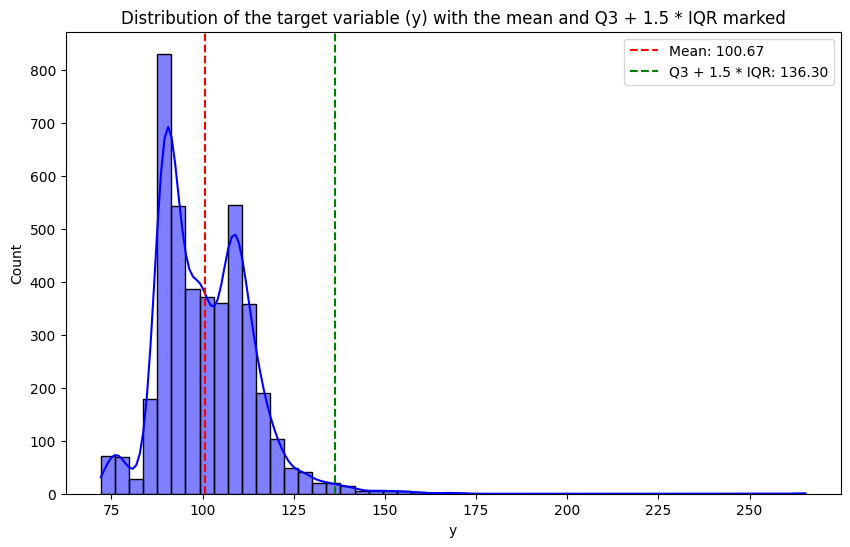

In [8]:
q1 = np.percentile(y_train, 25)
q3 = np.percentile(y_train, 75)
iqr = q3 - q1

# Compute highest 0.35% density
upper_bound = q3 + 1.5 * iqr
# Mean of target
mean = np.mean(y_train)

plt.figure(figsize=(10, 6))

sns.histplot(y_train, kde=True, bins=50, color='blue')

plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(upper_bound, color='green', linestyle='--', label=f'Q3 + 1.5 * IQR: {upper_bound:.2f}')

# Legend
plt.title('Distribution of the target variable (y) with the mean and Q3 + 1.5 * IQR marked')
plt.legend()

plt.show()


In [9]:
mask = y_train <= upper_bound

# Filtering X_train and y_train
X_train = X_train[mask]
y_train_cleaned = y_train[mask]

print(f"Removed {len(y_train) - len(y_train_cleaned)} outliers.")

y_train = y_train_cleaned


Removed 50 outliers.


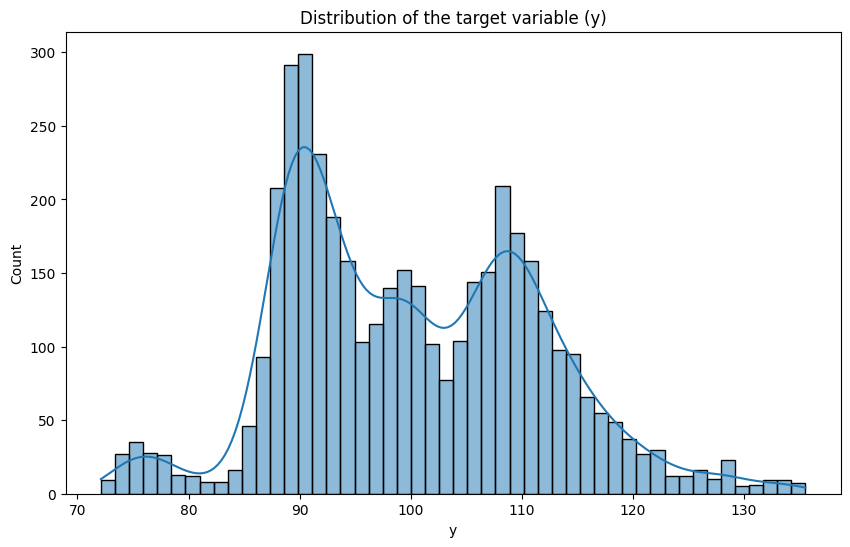

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True, bins=50)
plt.title('Distribution of the target variable (y)')
plt.show()

### 3.5 Categorial data

In [11]:
X_train_categorial_data = X_train.select_dtypes(object)
X_train_categorial_data

X0 X1  X2 X3 X4  X5 X6 X8
0      k  v  at  a  d   u  j  o
1      k  t  av  e  d   y  l  o
2     az  w   n  c  d   x  j  x
3     az  t   n  f  d   x  l  e
4     az  v   n  f  d   h  d  n
...   .. ..  .. .. ..  .. .. ..
4204  ak  s  as  c  d  aa  d  q
4205   j  o   t  d  d  aa  h  h
4206  ak  v   r  a  d  aa  g  e
4207  al  r   e  f  d  aa  l  u
4208   z  r  ae  c  d  aa  g  w

[4159 rows x 8 columns]

### 3.5.2 The impact of each categorical column on Y

X0


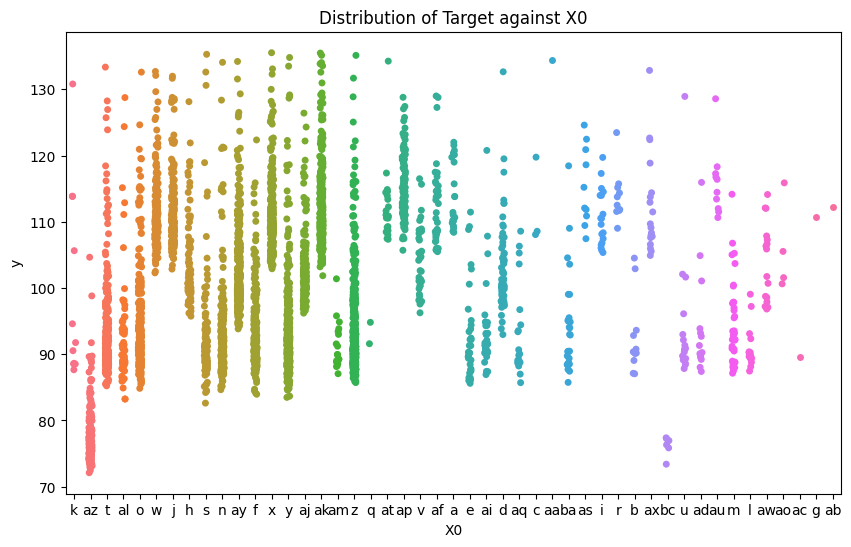

X1


C:\Users\micha\AppData\Local\Temp\ipykernel_3508\2485752044.py:5: UserWarning: The palette list has more values (47) than needed (27), which may not be intended.
  sns.stripplot(x=feature, y=y_train, data=df, hue=feature, palette=palette, legend=False)


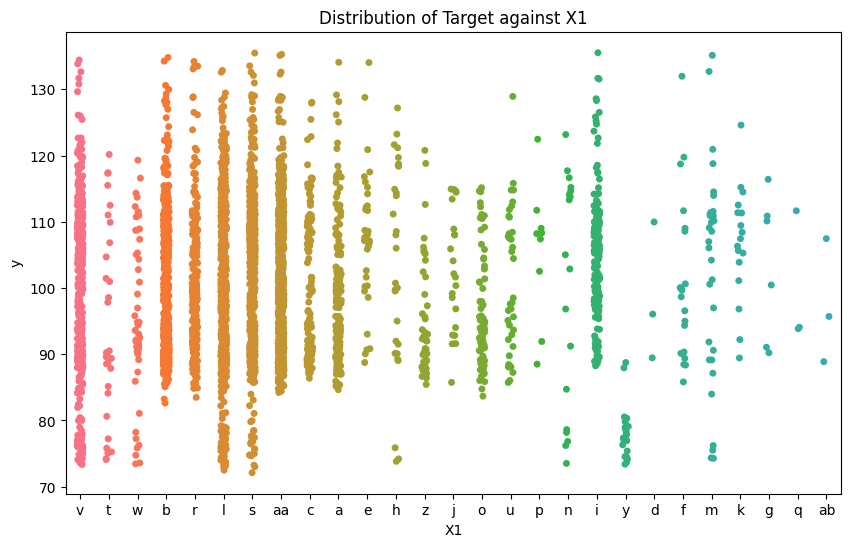

X2


C:\Users\micha\AppData\Local\Temp\ipykernel_3508\2485752044.py:5: UserWarning: The palette list has more values (47) than needed (43), which may not be intended.
  sns.stripplot(x=feature, y=y_train, data=df, hue=feature, palette=palette, legend=False)


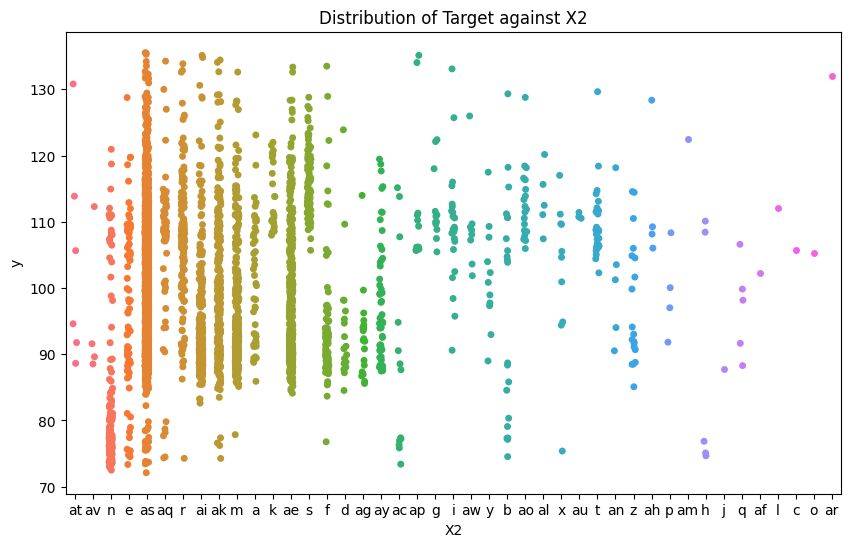

X3


C:\Users\micha\AppData\Local\Temp\ipykernel_3508\2485752044.py:5: UserWarning: The palette list has more values (47) than needed (7), which may not be intended.
  sns.stripplot(x=feature, y=y_train, data=df, hue=feature, palette=palette, legend=False)


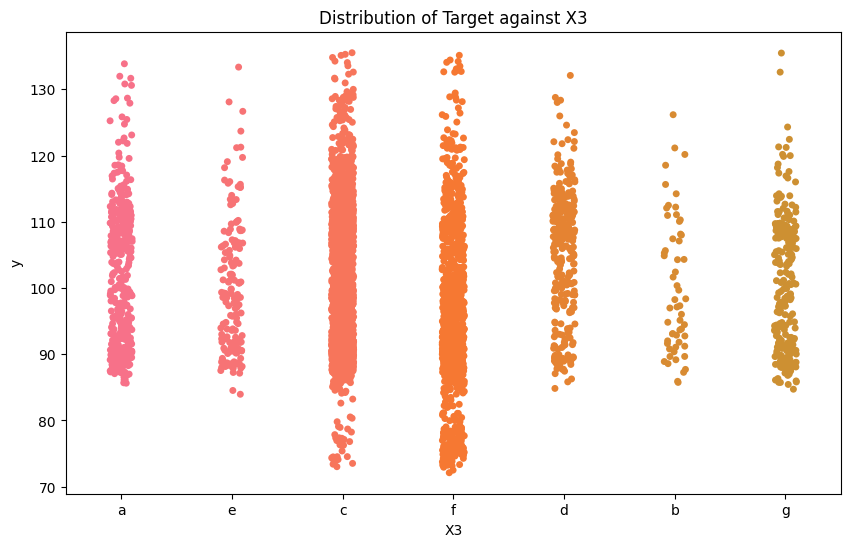

X4


C:\Users\micha\AppData\Local\Temp\ipykernel_3508\2485752044.py:5: UserWarning: The palette list has more values (47) than needed (4), which may not be intended.
  sns.stripplot(x=feature, y=y_train, data=df, hue=feature, palette=palette, legend=False)


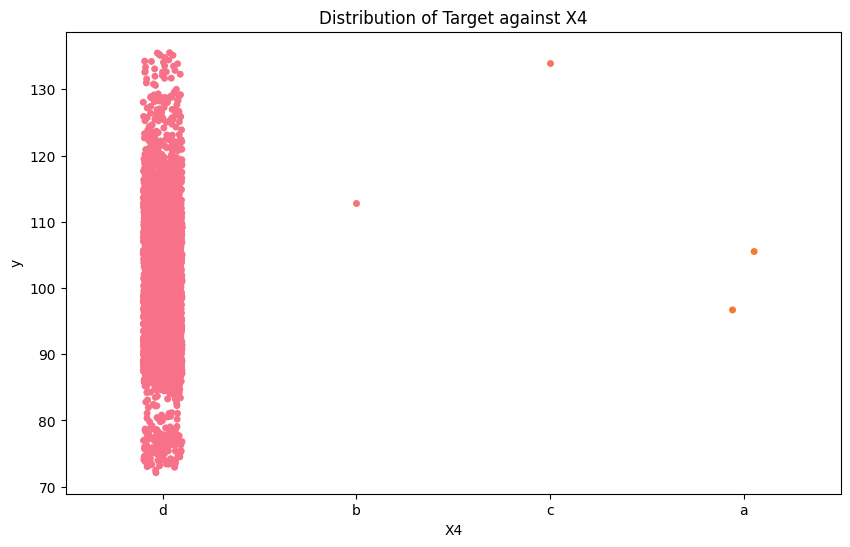

X5


C:\Users\micha\AppData\Local\Temp\ipykernel_3508\2485752044.py:5: UserWarning: The palette list has more values (47) than needed (29), which may not be intended.
  sns.stripplot(x=feature, y=y_train, data=df, hue=feature, palette=palette, legend=False)


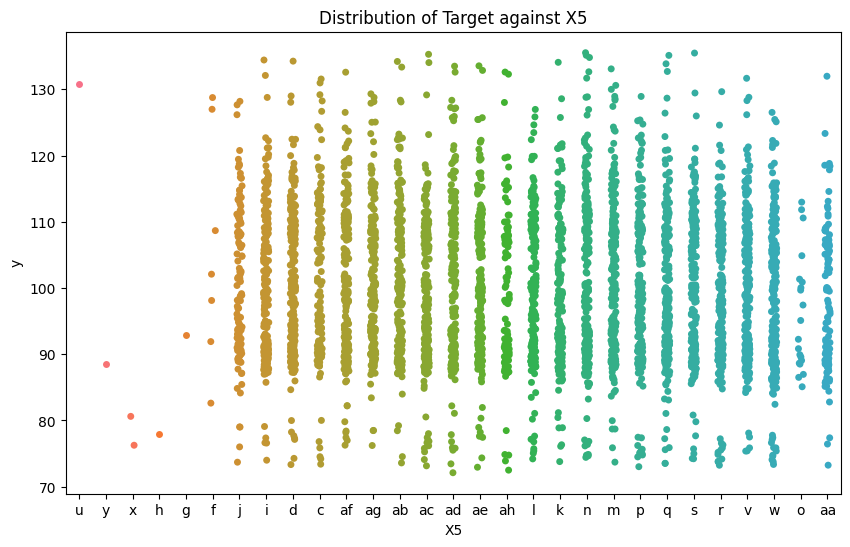

X6


C:\Users\micha\AppData\Local\Temp\ipykernel_3508\2485752044.py:5: UserWarning: The palette list has more values (47) than needed (12), which may not be intended.
  sns.stripplot(x=feature, y=y_train, data=df, hue=feature, palette=palette, legend=False)


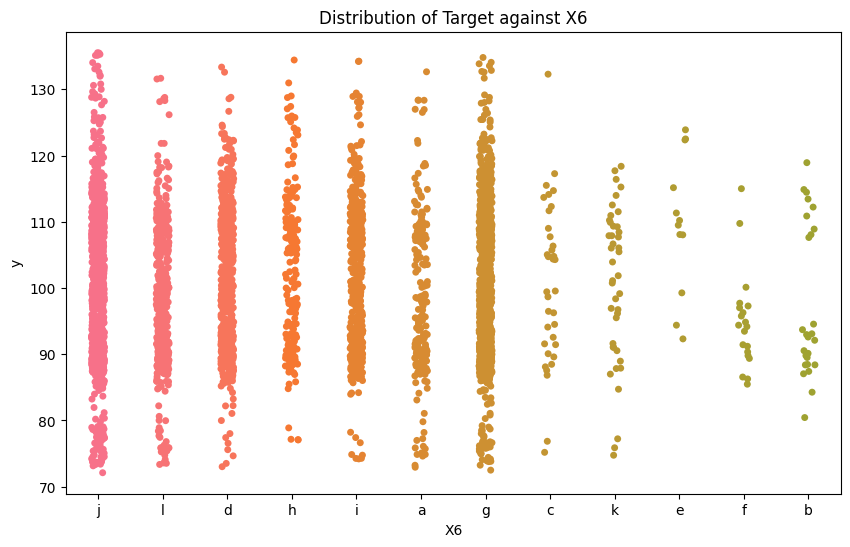

X8


C:\Users\micha\AppData\Local\Temp\ipykernel_3508\2485752044.py:5: UserWarning: The palette list has more values (47) than needed (25), which may not be intended.
  sns.stripplot(x=feature, y=y_train, data=df, hue=feature, palette=palette, legend=False)


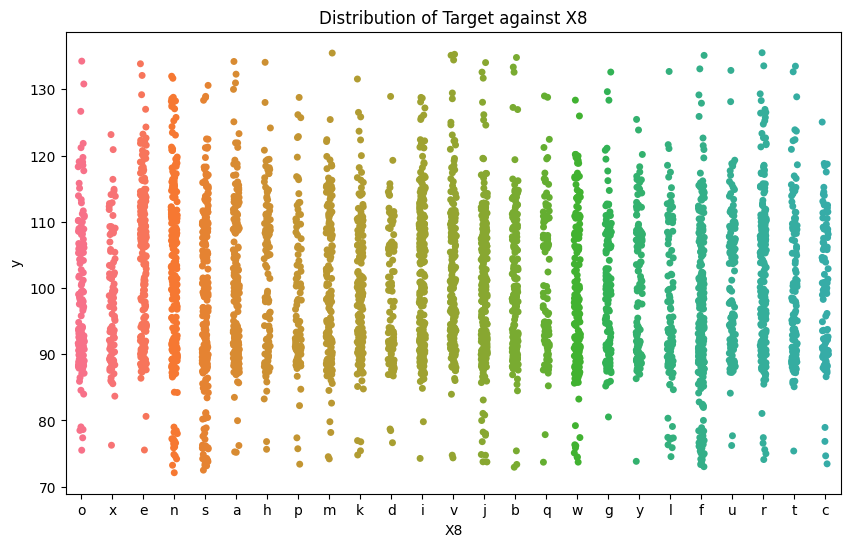

In [12]:
def categorical_distribution_viz(df, feature):
    plt.figure(figsize=(10,6))
    # Visualization
    palette = sns.color_palette("husl", len(train_data["X0"].unique().tolist())) 
    sns.stripplot(x=feature, y=y_train, data=df, hue=feature, palette=palette, legend=False)
    plt.title(f'Distribution of Target against {feature}')
    plt.show()

for coulmn in X_train_categorial_data.columns:
    print(coulmn)
    categorical_distribution_viz(X_train_categorial_data, coulmn)

In [13]:
X_train = X_train.drop(columns=['X4'])
X_test = X_test.drop(columns=['X4'])

### 3.5.3 Encodowanie zmiennych kategorialnych

In [14]:
encoder = EncodeCategorical()

X_train = encoder.encode(df=X_train)
X_test = encoder.encode(df=X_test)

In [15]:
X_train.iloc[:, -20:]
#train_data.iloc[:, -24:]

X0_splitted_char1  X0_splitted_char2  X1_single_char  X1_splitted_char1  \
0                     0                  0              22                  0   
1                     0                  0              20                  0   
2                     1                 26              23                  0   
3                     1                 26              20                  0   
4                     1                 26              22                  0   
...                 ...                ...             ...                ...   
4204                  1                 11              19                  0   
4205                  0                  0              15                  0   
4206                  1                 11              22                  0   
4207                  1                 12              18                  0   
4208                  0                  0              18                  0   

      X1_splitted_char2  X2_single_char  X2_splitted_char1  X2_splitted_char2  \
0                     0               0                  1                 20   
1                     0               0                  1                 22   
2                     0              14                  0                  0   
3                     0              14                  0                  0   
4                     0              14                  0                  0   
...                 ...             ...                ...                ...   
4204                  0               0                  1                 19   
4205                  0              20                  0                  0   
4206                  0              18                  0                  0   
4207                  0               5                  0                  0   
4208                  0               0                  1                  5   

      X3_single_char  X3_splitted_char1  X3_splitted_char2  X5_single_char  \
0                  1                 14                 14              21   
1                  5                 14                 14              25   
2                  3                 14                 14              24   
3                  6                 14                 14              24   
4                  6                 14                 14               8   
...              ...                ...                ...             ...   
4204               3                 14                 14               0   
4205               4                 14                 14               0   
4206               1                 14                 14               0   
4207               6                 14                 14               0   
4208               3                 14                 14               0   

      X5_splitted_char1  X5_splitted_char2  X6_single_char  X6_splitted_char1  \
0                     0                  0              10                 14   
1                     0                  0              12                 14   
2                     0                  0              10                 14   
3                     0                  0              12                 14   
4                     0                  0               4                 14   
...                 ...                ...             ...                ...   
4204                  1                  1               4                 14   
4205                  1                  1               8                 14   
4206                  1                  1               7                 14   
4207                  1                  1              12                 14   
4208                  1                  1               7                 14   

      X6_splitted_char2  X8_single_char  X8_splitted_char1  X8_splitted_char2  
0                    14              15                 14            

### 3.6 Analyse binary columns

In [16]:
binary_columns = [col for col in X_train.columns if X_train[col].nunique() == 2]
print(f"Number of binary columns: {len(binary_columns)}")

Number of binary columns: 358


In [17]:
zeros_count_list = []
ones_count_list = []
binary_summary = {}

for column in binary_columns:
    zeros_count = (X_train[column]==0).sum()
    ones_count = (X_train[column]==1).sum()

    zeros_count_list.append(zeros_count)
    ones_count_list.append(ones_count)

    binary_summary[column] = (zeros_count, ones_count)

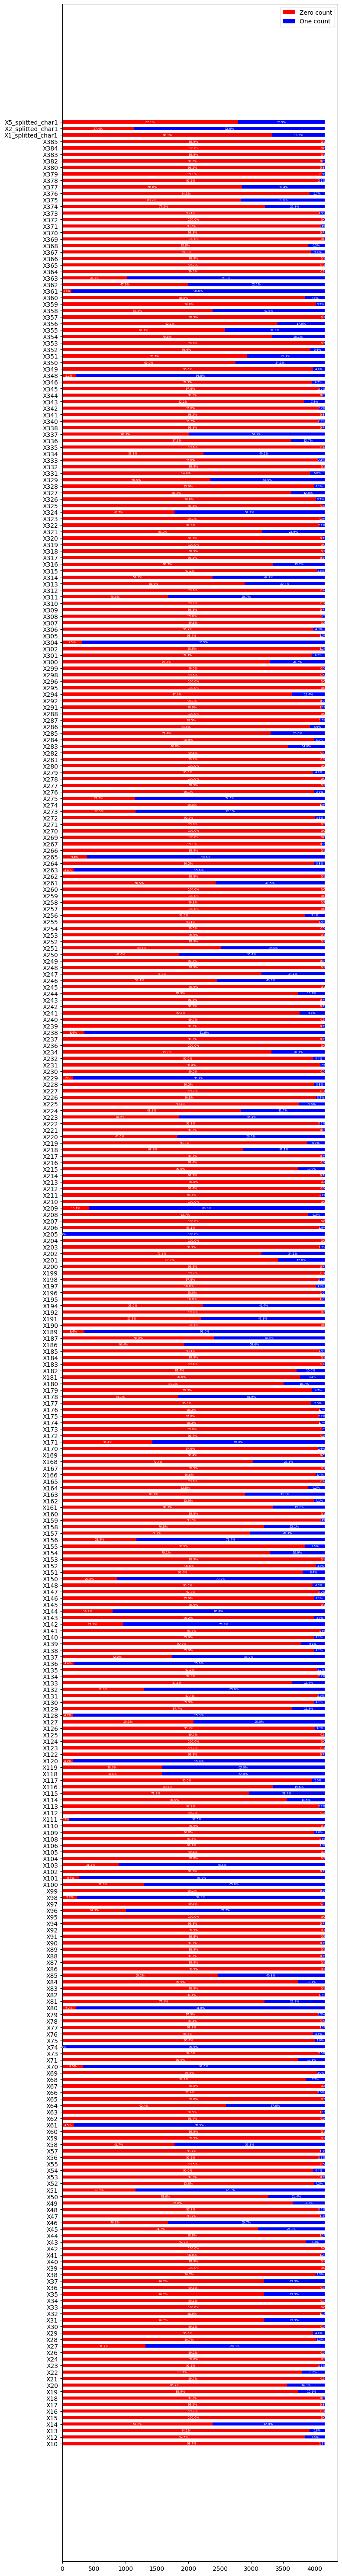

In [18]:
from plots import BinaryEDAPlots

eda_plots = BinaryEDAPlots(binary_columns, zeros_count_list, ones_count_list)
eda_plots.plot_binary_distribution()

In [19]:
binary_columns_to_less_unique = []

for column, (zeros, ones) in binary_summary.items():
    if zeros < 4 or ones < 4:
        binary_columns_to_less_unique.append(column)

print(f"Columns where there are less than 4 occurrences of the binary: {len(binary_columns_to_less_unique)}")

X_train.drop(columns=binary_columns_to_less_unique, inplace=True)

Columns where there are less than 4 occurrences of the binary: 35


# 4 Train / Val split

In [20]:
X_train_splitted, X_val_splitted, y_train_splitted, y_val_splitted = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 5 Reduction dimension - With no positive results

In [21]:
# from sklearn.decomposition import PCA

# # For 0.95, 0.99, 0.999, 0.9999 - Small reduction for models of R2 score
# pca = PCA(n_components=0.999)
# X_train_pca  = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_val)

# print(f"Number of dimensions after reduction: {pca.n_components_}")

# X_train = X_train_pca
# X_val = X_test_pca

In [22]:
# from sklearn.decomposition import KernelPCA

# kpca = KernelPCA(n_components=300, gamma=None, kernel="linear")
# kpca.fit(X_train, y_train)
# X_train_kpca = kpca.transform(X_train)
# X_val_kpca = kpca.transform(X_val)

# X_train = X_train_kpca
# X_val = X_val_kpca

# 6 Searching for best model

### 6.1 Compare models

In [23]:
params = {'monotone_constraints': "(1, 0)"}

models = {
    'LGBM Regression': LGBMRegressor(verbose=-1),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'SVR': SVR(),
    'XGBR': XGBRegressor(**params),
    'Random Forest Regression': RandomForestRegressor(),
    'CatBoost Regression': CatBoostRegressor(silent=True)
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"Model: {name}")
    
    model.fit(X_train_splitted, y_train_splitted)

    y_train_splitted_pred = model.predict(X_train_splitted)
    y_val_splitted_pred = model.predict(X_val_splitted)
    
    # Compute R^2 score
    r2_train = r2_score(y_train_splitted, y_train_splitted_pred)
    r2_val = r2_score(y_val_splitted, y_val_splitted_pred)

    print(f"R2 Train: {r2_train}")
    print(f"R2 Val: {r2_val}")
    print("\n" + "-"*50 + "\n")

Model: LGBM Regression
R2 Train: 0.8035986330889333
R2 Val: 0.6112464867615128

--------------------------------------------------

Model: Ridge Regression
R2 Train: 0.6714821763070684
R2 Val: 0.6060212182088478

--------------------------------------------------

Model: Lasso Regression
R2 Train: 0.4477767745054899
R2 Val: 0.46098076864972537

--------------------------------------------------

Model: SVR
R2 Train: 0.27705624000731643
R2 Val: 0.29413298040336244

--------------------------------------------------

Model: XGBR
R2 Train: 0.9061346037590982
R2 Val: 0.5410490908820914

--------------------------------------------------

Model: Random Forest Regression
R2 Train: 0.9302846323234202
R2 Val: 0.5890908000485973

--------------------------------------------------

Model: CatBoost Regression
R2 Train: 0.8238608329701956
R2 Val: 0.6110273887534317

--------------------------------------------------



### 6.2 LGBMR - Fitting parameters

In [27]:
model = LGBMRegressor()

param_grid = {
    'learning_rate': [0.03, 0.05, 0.07],
    'n_estimators': [75, 100, 125],
    'max_depth': [2, 3, 4],
    'num_leaves': [20, 25],
    'min_child_samples': [5, 10, 20]
}

scoring = make_scorer(r2_score)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=2, verbose=1) # Cross validation set up to 2 to speed up training
grid_search.fit(X_train_splitted, y_train_splitted)

print("Best params: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_val_splitted_pred_grid_search = best_model.predict(X_val_splitted)

r2 = r2_score(y_val_splitted, y_val_splitted_pred_grid_search)
print(f"R² on validation dataset: {r2}")

Fitting 2 folds for each of 162 candidates, totalling 324 fits
Best params:  {'learning_rate': 0.07, 'max_depth': 3, 'min_child_samples': 5, 'n_estimators': 75, 'num_leaves': 20}
R² on validation dataset: 0.6394870595796527


### 6.3 Catboost - Fitting parameters

In [25]:
model = CatBoostRegressor()

param_grid = {
    'learning_rate': [0.01, 0.03, 0.5],
    'n_estimators': [100, 250, 500],
    'max_depth': [4, 5, 7],
    'min_child_samples': [3, 5, 10]
}

scoring = make_scorer(r2_score)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=2, verbose=1)# Cross validation set up to 2 to speed up training
grid_search.fit(X_train_splitted, y_train_splitted)

print("Best params: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_val_splitted_pred_grid_search = best_model.predict(X_val_splitted)

r2 = r2_score(y_val_splitted, y_val_splitted_pred_grid_search)
print(f"R² on validation dataset: {r2}")

Fitting 2 folds for each of 81 candidates, totalling 162 fits
0:	learn: 11.5036220	total: 4.91ms	remaining: 486ms
1:	learn: 11.4323263	total: 8.45ms	remaining: 414ms
2:	learn: 11.3681965	total: 11.7ms	remaining: 379ms
3:	learn: 11.3093623	total: 17.9ms	remaining: 430ms
4:	learn: 11.2505127	total: 21.1ms	remaining: 400ms
5:	learn: 11.1870918	total: 24ms	remaining: 376ms
6:	learn: 11.1240699	total: 27.3ms	remaining: 362ms
7:	learn: 11.0639443	total: 32.8ms	remaining: 377ms
8:	learn: 11.0090726	total: 36ms	remaining: 364ms
9:	learn: 10.9467141	total: 39ms	remaining: 351ms
10:	learn: 10.8883615	total: 41.9ms	remaining: 339ms
11:	learn: 10.8319354	total: 46.2ms	remaining: 339ms
12:	learn: 10.7695026	total: 50.1ms	remaining: 335ms
13:	learn: 10.7100530	total: 53ms	remaining: 326ms
14:	learn: 10.6530954	total: 56.1ms	remaining: 318ms
15:	learn: 10.5944170	total: 59ms	remaining: 310ms
16:	learn: 10.5392150	total: 64.4ms	remaining: 315ms
17:	learn: 10.4859508	total: 67.4ms	remaining: 307ms
18:	

# 7 Training on the entire train data

In [30]:
model = CatBoostRegressor(
    learning_rate=0.03,
    n_estimators=250,   
    max_depth=4, 
    min_child_samples=3
)

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
r2_scores = []

# Cross validation
for train_index, test_index in kf.split(X_train, y_train):

    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Trening
    model.fit(X_train_fold, y_train_fold)

    # Validation
    y_val_pred = model.predict(X_val_fold)

    # Compute R² score
    r2 = r2_score(y_val_fold, y_val_pred)
    r2_scores.append(r2)

mean_r2 = np.mean(r2_scores)
print(f"Mean R² after {k_folds}-fold cross-validation: {mean_r2}")

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

0:	learn: 11.3099433	total: 3.79ms	remaining: 942ms
1:	learn: 11.0990165	total: 7.42ms	remaining: 921ms
2:	learn: 10.9065710	total: 10.7ms	remaining: 881ms
3:	learn: 10.7121730	total: 13.7ms	remaining: 842ms
4:	learn: 10.5282556	total: 16.5ms	remaining: 807ms
5:	learn: 10.3555733	total: 20.2ms	remaining: 821ms
6:	learn: 10.2008393	total: 23.7ms	remaining: 822ms
7:	learn: 10.0469035	total: 26.8ms	remaining: 811ms
8:	learn: 9.8909994	total: 29.7ms	remaining: 795ms
9:	learn: 9.7613823	total: 32.5ms	remaining: 780ms
10:	learn: 9.6291337	total: 36ms	remaining: 782ms
11:	learn: 9.5015600	total: 39.3ms	remaining: 779ms
12:	learn: 9.3677253	total: 42.9ms	remaining: 782ms
13:	learn: 9.2547720	total: 46.4ms	remaining: 782ms
14:	learn: 9.1409505	total: 49.7ms	remaining: 778ms
15:	learn: 9.0229471	total: 53ms	remaining: 776ms
16:	learn: 8.9144369	total: 56.3ms	remaining: 771ms
17:	learn: 8.8089906	total: 59.2ms	remaining: 763ms
18:	learn: 8.7183552	total: 62.1ms	remaining: 755ms
19:	learn: 8.63276

# 8 Export results

In [32]:
submission=pd.read_csv("data/raw/sample_submission.csv")
submission['y'] = y_test_pred
submission.head() 

ID           y
0   1   78.172262
1   2   93.942006
2   3   78.523321
3   4   77.185741
4   5  109.727225

In [33]:
submission.to_csv("data/raw/kaggle_submission.csv", index=False)